<a href="https://colab.research.google.com/github/NaomiInbal/anomaly-detection-and-trajectory-classification/blob/LSTM/xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import csv
import time
import random
import math

def calculate_next_point(last_x, last_y, angle, distance):
    c = last_x + 10
    d = last_y + 10
    while True:
        x = last_x + distance * math.cos(angle)
        y = last_y + distance * math.sin(angle)
        # Check distance condition
        if math.sqrt((x - c)**2 + (y - d)**2) <= 5:
            break
        else:
            angle += math.pi / 180  # Increase angle by 1 degree and retry

    return x, y

def calculate_accident_point(last_x, last_y, angle, distance):
    c = last_x + 10
    d = last_y + 10
    while True:
        x = last_x + distance * math.cos(angle)
        y = last_y + distance * math.sin(angle)
        # Check distance condition
        if (math.sqrt((x - c)**2 + (y - d)**2) > 11) and (y > last_y):
            break
        else:
            angle += math.radians(5)  # Increase angle by 5 degree and retry

    return x, y

def generate_route_points(num_points, distance_increment, noisy_points, has_accident, vehicle_id):
    route_points = []
    current_time = int(time.time())

    for i in range(num_points):
        x = y = i * distance_increment
        global_time = current_time + i * 10  # Increase timestamp by 10 seconds for each point
        accident_value = 1 if i in noisy_points else 0  # Set accident column value based on noisy points
        route_points.append((x, y, global_time, accident_value, vehicle_id))  # Include vehicle_id column

    accident_point = random.choice(noisy_points) if has_accident else -1
    for random_index in noisy_points:
        last_x, last_y, _, _, _ = route_points[random_index - 1]  # Ignore vehicle_id column
        angle = random.uniform(0, math.pi / 4)  # Limit to 45-degree angle

        # Calculate the random noisy point with a 10-meter distance
        noisy_x, noisy_y = calculate_next_point(last_x, last_y, angle, distance_increment)
        route_points.insert(random_index, (noisy_x, noisy_y, current_time + random_index * 10,0, vehicle_id))

        # Remove the next point after the noisy point
        route_points.pop(random_index + 1)

        # Introduce accident in vehicles with 50% probability
        if has_accident and random_index == accident_point:
            accident_x, accident_y = calculate_accident_point(last_x, last_y, angle, distance_increment)
            route_points[accident_point] = (accident_x, accident_y, current_time + accident_point * 10, 1, vehicle_id)
            print (vehicle_id)

    return route_points

def write_to_csv(filename, data):
    with open(filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['local_x', 'local_y', 'global_time', 'accident', 'vehicle_id'])
        for row in data:
            csv_writer.writerow(row)


if __name__ == "__main__":
    num_points = 36  # Number of points along the curve
    distance_increment = 10  # Increment in meters between points
    num_noisy_points = 20  # Number of noisy points

    # Choose 7 random indices for noisy points
    noisy_points = random.sample(range(1, num_points - 1), num_noisy_points)

    combined_route_points = []

    vehicle_data = {}  # Dictionary to store vehicle data
    for vehicle_id in range(0, 4):  # Create 5 different vehicle tracks
        has_accident = random.random() < 0.2  # 50% probability of having an accident
        route_points = generate_route_points(num_points, distance_increment, noisy_points, has_accident, f'vehicle_{vehicle_id}')
        combined_route_points.extend(route_points)

        vehicle_data[f'vehicle_{vehicle_id}'] = has_accident

#Check if a vehicle has an accident, then update all rows for that vehicle
    for vehicle_id, has_accident in vehicle_data.items():
        if has_accident:
            for i in range(len(combined_route_points)):
                if combined_route_points[i][4] == vehicle_id:
                    combined_route_points[i] = (combined_route_points[i][0], combined_route_points[i][1],
                                               combined_route_points[i][2], 1, vehicle_id)
    write_to_csv('combined_vehicle_tracks2.csv', combined_route_points)


vehicle_2


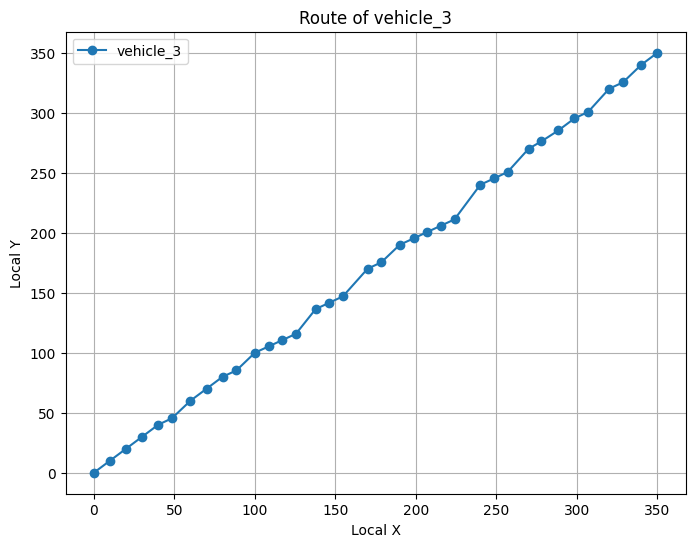

In [ ]:
import csv
import time
import random
import math
import matplotlib.pyplot as plt

# ... Rest of your code ...

# Choose a specific vehicle_id to plot (for example, 'vehicle_1')
vehicle_to_plot = 'vehicle_3'

# Collect the x and y coordinates for the selected vehicle
vehicle_x_coords = []
vehicle_y_coords = []

for row in combined_route_points:
    if row[4] == vehicle_to_plot:
        vehicle_x_coords.append(row[0])
        vehicle_y_coords.append(row[1])

# Plot the route of the selected vehicle
plt.figure(figsize=(8, 6))
plt.plot(vehicle_x_coords, vehicle_y_coords, marker='o', label=vehicle_to_plot)
plt.xlabel('Local X')
plt.ylabel('Local Y')
plt.title(f'Route of {vehicle_to_plot}')
plt.legend()
plt.grid(True)
plt.show()


print the first five rows from the tracks_database.csv file:
   local_x  local_y  global_time  accident vehicle_id
0      0.0      0.0   1692697656         0  vehicle_1
1     10.0     10.0   1692697666         0  vehicle_1
2     20.0     20.0   1692697676         0  vehicle_1
3     30.0     30.0   1692697686         0  vehicle_1
4     40.0     40.0   1692697696         0  vehicle_1


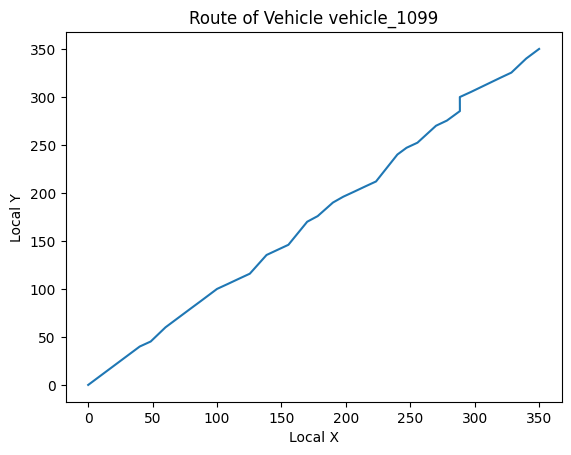

NameError: ignored

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import ast
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras import backend as K


# read the tracks from path of csv file . and presents 10 tracks in a table
def import_data():
    # read the tracks from path of csv file . and presents 10 tracks in a table
    pd.options.display.max_columns = 25
    df = pd.read_csv("combined_vehicle_tracks.csv")
    # Define the file path and name for the new file
    file_path = "tracks_database.csv"
    # Write the DataFrame to a new CSV file
    df.to_csv(file_path, index=False)
    print("print the first five rows from the tracks_database.csv file:")
    print(df.head(5))
    df = pd.DataFrame(df)
    return df


# Drawing a track by ID
# params: 1. pointer to data frame. 2.Define the vehicle id for which you want to draw the route
def drawing_track(df, vehicle_id):
    # Filter the dataframe to keep only the data for the selected vehicle
    df_vehicle = df[df['vehicle_id'] == vehicle_id]
    # Extract the local_x and local_y coordinates for the selected vehicle
    x = df_vehicle['local_x'].tolist()
    y = df_vehicle['local_y'].tolist()
    # Plot the route
    plt.plot(x,y)
    plt.xlabel("Local X")
    plt.ylabel("Local Y")
    plt.title(f"Route of Vehicle {vehicle_id}")
    plt.show()


#Normalize the data,
#The fit_transform() method is used to fit the data into a model and transform it into a form that is more suitable for the model in a single step.
def data_normalization(df_modified):
    # Initialize the scaler
    scaler = MinMaxScaler()

    # Normalize the local_x and local_y columns and add them as new columns in the DataFrame
    df_modified['local_x_norm'] = (df_modified['local_x'] - df_modified['local_x'].mean())/df_modified['local_x'].std()
    df_modified['local_y_norm'] = (df_modified['local_y'] - df_modified['local_y'].mean())/df_modified['local_y'].std()
    df_modified['global_time_norm'] = (df_modified['global_time'] - df_modified['global_time'].mean())/df_modified['global_time'].std()
    # df_modified['local_x_norm'] = scaler.fit_transform(df_modified[['local_x_norm']])
    # df_modified['local_y_norm'] = scaler.fit_transform(df_modified[['local_y_norm']])
    # Write the DataFrame to the same CSV file
    df_modified.to_csv("tracks_database_modified.csv", index=False)
    # Review the indicators.
    print(df_modified.describe())
    return df_modified


#Group by the cordinates to a tracks
def group_tracks(df_modified):
    # Load data from CSV file
    df_modified = pd.read_csv("tracks_database_modified.csv")

    # Sort the DataFrame by 'global_time' to preserve the original order
    sorted_df = df_modified.sort_values('global_time')

    # Group by 'vehicle_id' and preserve the original order by using 'first' aggregation function
    grouped = sorted_df.groupby("vehicle_id").apply(lambda x: pd.Series({
        "vehicle_id": x["vehicle_id"].iloc[0],  # Add vehicle_id column
        "local_x_norm": np.array(x["local_x_norm"]).astype(float).tolist(),
        "local_y_norm": x["local_y_norm"].astype(float).tolist(),
        "global_time_norm": x["global_time_norm"].astype(float).tolist(),
        "accident": int(x["accident"].all())
    }))

    # Reset the index to remove the multi-level index created by groupby
    grouped.reset_index(drop=True, inplace=True)

    # Save grouped data to CSV file
    grouped.to_csv("tracks_database_modified.csv", index=False)
    return grouped


def reshape_tracks(df_modified):
        # Create a list to store the 3D array for each route
        routes_data = []

        # Define the maximum route length
        max_route_length = 0

        # Loop over each route and store its data in a 3D array
        for x, y, time in zip(df_modified['local_x_norm'], df_modified['local_y_norm'], df_modified['global_time_norm']):
            route_data = list(zip(x, y, time))

            # Update the maximum route length if needed
            if len(route_data) > max_route_length:
                max_route_length = len(route_data)

            routes_data.append(route_data)

        # Pad sequences with tuples of zeros to ensure consistent length
        for i in range(len(routes_data)):
            route_data = routes_data[i]
            padded_data = [(0, 0, 0)] * (max_route_length - len(route_data)) + route_data
            routes_data[i] = padded_data


        # Convert the list of 3D arrays into a 3D NumPy array
        routes_data = np.array(routes_data)
        return routes_data,max_route_length


def read_y(df_modified):
    return df_modified['accident']


#Shows how many examples we have of each type to see if the database is balanced
def is_balanced_database(df_modified):
    print(df_modified['accident'].value_counts())

#=============================================================================================================================================
def oneHotEndcoding(Y_train, Y_test):
    Y_train_oh = pd.get_dummies(Y_train, prefix='type')
    Y_test_oh = pd.get_dummies(Y_test, prefix='type')
    return Y_train_oh, Y_test_oh


def callbacks_function(name):
  early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='min', restore_best_weights=True)
  monitor = tf.keras.callbacks.ModelCheckpoint(name, monitor='val_loss', verbose=0,save_best_only=False
                                               ,save_weights_only=False,mode='min')

  def scheduler(epoch, lr):
    if epoch%5 == 0:
      lr = lr/2
    return lr

  lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

  return early_stop, monitor, lr_schedule


def f1(y_true, y_pred):
  def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

  def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision
  precision = precision(y_true, y_pred)
  recall = recall(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+tf.keras.backend.epsilon()))

def model_comiple_run(model,X_train,Y_train,X_test,y_test,callbacks):
  #typeX_test - <class 'numpy.ndarray'>
  #type y_test - <class 'pandas.core.frame.DataFrame'>
  # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'precision', 'recall', 'f1_score'])
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1])
  model_history = model.fit(X_train, Y_train,validation_data=(X_test, y_test), verbose=1, epochs= 50)
  # batch_size=32, validation_data=(X_test,y_test)\,callbacks=callbacks,verbose=1)
  return model_history

# max_length = max(len(subarray[0]) for subarray in arr) # Find the maximum length of sub-arrays


#function definition for ploting the accuracy graph for train and validation sets.
def model_plot(model_history, type = None, plot_all = True):
  plt.plot()
  if plot_all:
    plt.plot(model_history.history['accuracy'], label = "Train accuracy")
    plt.plot(model_history.history['val_accuracy'], label = "Val accuracy")
    plt.xlabel("Epoch (iteration)")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend()
    plt.show()
    plt.plot(model_history.history['loss'], label = "Train loss")
    plt.plot(model_history.history['val_loss'], label = "Val loss")
    plt.xlabel("Epoch (iteration)")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend()
    plt.show()
    plt.plot(model_history.history['f1'], label = "Train f1")
    plt.plot(model_history.history['val_f1'], label = "Val f1")
    plt.xlabel("Epoch (iteration)")
    plt.ylabel("F1")
    plt.grid()
    plt.legend()
    plt.show()
  else:
    if type=='accuracy':
      plt.plot(model_history.history['accuracy'], label = "Train accuracy")
      plt.plot(model_history.history['val_accuracy'], label = "val_accuracy")
    if type=='loss':
      plt.plot(model_history.history['loss'], label = "Train loss")
      plt.plot(model_history.history['val_loss'], label = "val_loss")
    if type=='f1':
      plt.plot(model_history.history['f1'], label = "Train f1")
      plt.plot(model_history.history['val_f1'], label = "val_f1")
    plt.legend()
    plt.show()
#=============================================================================================================================================

#LSTM - model 1
def lstm_model1(x,y,max_route_length):
    # Encode the target variable
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(y)
    labels_encoded = labels_encoded.reshape((len(y), 1))

    # Pad sequences to ensure consistent length
    # test_size - determines the percentage division into test and train.
    # random_state - Selects regular examples for training and testing in all running.
    X_train, X_test, y_train, y_test = train_test_split(x, labels_encoded, test_size=0.2,
                                                        random_state=42)

    # y_train, y_test = oneHotEndcoding(y_train, y_test)

    # Experiment 1: hidden_layers = 1, total_nodes = 64
    # Define the LSTM model
    model = Sequential()
    # input_shape - we define an LSTM model with an input shape of (param1, param2), meaning it takes in a sequence of param1 inputs with param2 feature each.
    model.add(LSTM(40, input_shape=(X_train.shape[1], X_train.shape[2])))
    # model.add(Dropout(0.2))
    model.add(Flatten())
    # The sigmoid activation function is commonly used for binary classification problems, where the output values range between 0 and 1
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model_name = 'First'
    early_stop, monitor, lr_schedule = callbacks_function(model_name)
    # Assuming X_train and X_test are your ragged nested sequences
    model_history = model_comiple_run(model, X_train, y_train, X_test, y_test,
                                      callbacks=[early_stop, monitor, lr_schedule])
    model_plot(model_history)
    # model.load_weights(model_name)
    # loss = model.evaluate(X_test, y_test, verbose=1, steps=X_test.shape[0]) # Evaluate the model
    # print('Final loss 9 (cross-entropy and accuracy and F1):', loss)

    loss = model.evaluate(X_test, y_test, verbose=1, steps=X_test.shape[0]) # evaluate the model
    print('Final loss 1 (cross-entropy and accuracy and F1):', loss)

    # # Classify new tracks using the trained model
    # new_track = [(102.4208282026001537,100.6556837362916167,1.7341556317074696),(4.4079540881162123, -2.4456476447699654, 1.734483396060324),(2.3953228814527225,-0.2356115532483141,1.7348111604131784),(2.3826916747892333,-0.0254120095153621,1.7351389247660327),(2.3700604681257427,0.1846240820062891,1.7354666891188872)]# Example new track values
    # new_track = [(0, 0, 0)] * (max_route_length - len(new_track)) + new_track
    # new_track = np.array(new_track)
    # new_track = new_track.reshape((1, new_track.shape[0], new_track.shape[1])) # Reshape to match LSTM input shape
    # # new_track = pad_sequences(new_track, maxlen=max_route_length)
    # prediction = model.predict(new_track)
    # # Decode the prediction
    # predicted_label = label_encoder.inverse_transform(np.round(prediction).astype(int))
    # # classification The new track
    # if prediction[0] >= 0.5:
    #     print("The new route is anomalous")
    # else:
    #     print("The new route is normal")



if __name__ == '__main__':
    data_frame = import_data()
    vehicle = "vehicle_1099"
    drawing_track(data_frame, vehicle)
    # sort_by_global_time(data_frame)
    drawing_track_before_and_after(data_frame, df_modified, vehicle_ids_with_noise)
    df_modified = data_normalization(df_modified)
    df_modified = group_tracks(df_modified)
    x,max_route_length = reshape_tracks(df_modified)
    y = read_y(df_modified)
    is_balanced_database(df_modified)
    lstm_model1(x,y,max_route_length)


In [ ]:
#xgboost=================================================================================================================================
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import ast
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras import backend as K


# read the tracks from path of csv file . and presents 10 tracks in a table
def import_data():
    # read the tracks from path of csv file . and presents 10 tracks in a table
    pd.options.display.max_columns = 25
    df = pd.read_csv("combined_vehicle_tracks.csv")
    # Define the file path and name for the new file
    file_path = "tracks_database.csv"
    # Write the DataFrame to a new CSV file
    df.to_csv(file_path, index=False)
    print("print the first five rows from the tracks_database.csv file:")
    print(df.head(5))
    df = pd.DataFrame(df)
    return df


# Drawing a track by ID
# params: 1. pointer to data frame. 2.Define the vehicle id for which you want to draw the route
def drawing_track(df, vehicle_id):
    # Filter the dataframe to keep only the data for the selected vehicle
    df_vehicle = df[df['vehicle_id'] == vehicle_id]
    # Extract the local_x and local_y coordinates for the selected vehicle
    x = df_vehicle['local_x'].tolist()
    y = df_vehicle['local_y'].tolist()
    # Plot the route
    plt.plot(x,y)
    plt.xlabel("Local X")
    plt.ylabel("Local Y")
    plt.title(f"Route of Vehicle {vehicle_id}")
    plt.show()


#Normalize the data,
#The fit_transform() method is used to fit the data into a model and transform it into a form that is more suitable for the model in a single step.
def data_normalization(df_modified):
    # Initialize the scaler
    scaler = MinMaxScaler()

    # Normalize the local_x and local_y columns and add them as new columns in the DataFrame
    df_modified['local_x_norm'] = (df_modified['local_x'] - df_modified['local_x'].mean())/df_modified['local_x'].std()
    df_modified['local_y_norm'] = (df_modified['local_y'] - df_modified['local_y'].mean())/df_modified['local_y'].std()
    df_modified['global_time_norm'] = (df_modified['global_time'] - df_modified['global_time'].mean())/df_modified['global_time'].std()
    # df_modified['local_x_norm'] = scaler.fit_transform(df_modified[['local_x_norm']])
    # df_modified['local_y_norm'] = scaler.fit_transform(df_modified[['local_y_norm']])
    # Write the DataFrame to the same CSV file
    df_modified.to_csv("tracks_database_modified.csv", index=False)
    # Review the indicators.
    print(df_modified.describe())
    return df_modified


#Group by the cordinates to a tracks
def group_tracks(df_modified):
    # Load data from CSV file
    df_modified = pd.read_csv("tracks_database_modified.csv")

    # Sort the DataFrame by 'global_time' to preserve the original order
    sorted_df = df_modified.sort_values('global_time')

    # Group by 'vehicle_id' and preserve the original order by using 'first' aggregation function
    grouped = sorted_df.groupby("vehicle_id").apply(lambda x: pd.Series({
        "vehicle_id": x["vehicle_id"].iloc[0],  # Add vehicle_id column
        "local_x_norm": np.array(x["local_x_norm"]).astype(float).tolist(),
        "local_y_norm": x["local_y_norm"].astype(float).tolist(),
        "global_time_norm": x["global_time_norm"].astype(float).tolist(),
        "accident": int(x["accident"].all())
    }))

    # Reset the index to remove the multi-level index created by groupby
    grouped.reset_index(drop=True, inplace=True)

    # Save grouped data to CSV file
    grouped.to_csv("tracks_database_modified.csv", index=False)
    return grouped


def reshape_tracks(df_modified):
        # Create a list to store the 3D array for each route
        routes_data = []

        # Define the maximum route length
        max_route_length = 0

        # Loop over each route and store its data in a 3D array
        for x, y, time in zip(df_modified['local_x_norm'], df_modified['local_y_norm'], df_modified['global_time_norm']):
            route_data = list(zip(x, y, time))

            # Update the maximum route length if needed
            if len(route_data) > max_route_length:
                max_route_length = len(route_data)

            routes_data.append(route_data)

        # Pad sequences with tuples of zeros to ensure consistent length
        for i in range(len(routes_data)):
            route_data = routes_data[i]
            padded_data = [(0, 0, 0)] * (max_route_length - len(route_data)) + route_data
            routes_data[i] = padded_data


        # Convert the list of 3D arrays into a 3D NumPy array
        routes_data = np.array(routes_data)
        return routes_data,max_route_length


def read_y(df_modified):
    return df_modified['accident']


#Shows how many examples we have of each type to see if the database is balanced
def is_balanced_database(df_modified):
    print(df_modified['accident'].value_counts())

#=============================================================================================================================================
def oneHotEndcoding(Y_train, Y_test):
    Y_train_oh = pd.get_dummies(Y_train, prefix='type')
    Y_test_oh = pd.get_dummies(Y_test, prefix='type')
    return Y_train_oh, Y_test_oh


def callbacks_function(name):
  early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='min', restore_best_weights=True)
  monitor = tf.keras.callbacks.ModelCheckpoint(name, monitor='val_loss', verbose=0,save_best_only=False
                                               ,save_weights_only=False,mode='min')

  def scheduler(epoch, lr):
    if epoch%5 == 0:
      lr = lr/2
    return lr

  lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

  return early_stop, monitor, lr_schedule


def f1(y_true, y_pred):
  def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

  def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision
  precision = precision(y_true, y_pred)
  recall = recall(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+tf.keras.backend.epsilon()))

def model_comiple_run(model,X_train,Y_train,X_test,y_test,callbacks):
  #typeX_test - <class 'numpy.ndarray'>
  #type y_test - <class 'pandas.core.frame.DataFrame'>
  # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'precision', 'recall', 'f1_score'])
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1])
  model_history = model.fit(X_train, Y_train,validation_data=(X_test, y_test), verbose=1, epochs= 50)
  # batch_size=32, validation_data=(X_test,y_test)\,callbacks=callbacks,verbose=1)
  return model_history

# max_length = max(len(subarray[0]) for subarray in arr) # Find the maximum length of sub-arrays


#function definition for ploting the accuracy graph for train and validation sets.
def model_plot(model_history, type = None, plot_all = True):
  plt.plot()
  if plot_all:
    plt.plot(model_history.history['accuracy'], label = "Train accuracy")
    plt.plot(model_history.history['val_accuracy'], label = "Val accuracy")
    plt.xlabel("Epoch (iteration)")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend()
    plt.show()
    plt.plot(model_history.history['loss'], label = "Train loss")
    plt.plot(model_history.history['val_loss'], label = "Val loss")
    plt.xlabel("Epoch (iteration)")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend()
    plt.show()
    plt.plot(model_history.history['f1'], label = "Train f1")
    plt.plot(model_history.history['val_f1'], label = "Val f1")
    plt.xlabel("Epoch (iteration)")
    plt.ylabel("F1")
    plt.grid()
    plt.legend()
    plt.show()
  else:
    if type=='accuracy':
      plt.plot(model_history.history['accuracy'], label = "Train accuracy")
      plt.plot(model_history.history['val_accuracy'], label = "val_accuracy")
    if type=='loss':
      plt.plot(model_history.history['loss'], label = "Train loss")
      plt.plot(model_history.history['val_loss'], label = "val_loss")
    if type=='f1':
      plt.plot(model_history.history['f1'], label = "Train f1")
      plt.plot(model_history.history['val_f1'], label = "val_f1")
    plt.legend()
    plt.show()
#=============================================================================================================================================

#LSTM - model 1
def lstm_model1(x,y,max_route_length):
    # Encode the target variable
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(y)
    labels_encoded = labels_encoded.reshape((len(y), 1))

    # Pad sequences to ensure consistent length
    # test_size - determines the percentage division into test and train.
    # random_state - Selects regular examples for training and testing in all running.
    X_train, X_test, y_train, y_test = train_test_split(x, labels_encoded, test_size=0.2,
                                                        random_state=42)

    xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
    xgb_classifier.fit(X_train, y_train)

# Evaluate the model on the test set
    accuracy = xgb_classifier.score(X_test, y_test)
    print("XGBoost Accuracy:", accuracy)

# You can also use the trained model for predictions
    predictions = xgb_classifier.predict(X_test)



if __name__ == '__main__':
    data_frame = import_data()
    vehicle = "vehicle_1099"
    drawing_track(data_frame, vehicle)
    vehicle_ids_with_noise,df_modified = add_noise(data_frame)
    drawing_track_before_and_after(data_frame, df_modified, vehicle_ids_with_noise)
    df_modified = data_normalization(df_modified)
    df_modified = group_tracks(df_modified)
    x,max_route_length = reshape_tracks(df_modified)
    y = read_y(df_modified)
    is_balanced_database(df_modified)
    lstm_model1(x,y,max_route_length)


In [ ]:
pip install xgboost

In [40]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
df = pd.read_csv("combined_vehicle_tracks2.csv")
dummies = pd.get_dummies(df['local_y'])
df = pd.concat([df, dummies], axis=1)
X = df[["local_x","local_y","global_time"]]
y = df["accident"]
seed = 42
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
model = XGBClassifier(subsample = 0.5, learning_rate = 0.1, max_depth = 4)
model.fit(X_train, y_train)
print(model)
y_pred = model.predict(X_test)
print(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
[1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0]
Accuracy: 56.82%


In [49]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv("combined_vehicle_tracks2.csv")

# Group the data by vehicle ID
vehicle_groups = df.groupby("vehicle_id")

# Create a dictionary to store vehicle predictions
vehicle_predictions = {}

# Loop through each vehicle group
for vehicle_id, group in vehicle_groups:
    # Choose features and target for the specific vehicle group
    X_vehicle = group[["local_x", "local_y", "global_time"]]
    y_vehicle = group["accident"]
    X_train, X_test, y_train, y_test = train_test_split(X_vehicle, y_vehicle, test_size=test_size, random_state=seed)
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    # Create and train the XGBoost model
    model = XGBClassifier(subsample=0.5, learning_rate=0.1, max_depth=4)
    model.fit(X_train, y_train)

    # Make prediction for the vehicle group
    y_pred_vehicle = model.predict(X_vehicle)

    # Store the prediction for the vehicle
    vehicle_predictions[vehicle_id] = y_pred_vehicle[0]  # Store just the first prediction

print(vehicle_predictions)
# Print the predictions for each vehicle
for vehicle_id, prediction in vehicle_predictions.items():
    if prediction == 1:
        print(f"Vehicle {vehicle_id}: Predicted to have an accident")
    else:
        print(f"Vehicle {vehicle_id}: Predicted not to have an accident")
print("Accuracy: %.2f%%" % (accuracy * 100.0))


{'vehicle_0': 0, 'vehicle_1': 0, 'vehicle_2': 0, 'vehicle_3': 0}
Vehicle vehicle_0: Predicted not to have an accident
Vehicle vehicle_1: Predicted not to have an accident
Vehicle vehicle_2: Predicted not to have an accident
Vehicle vehicle_3: Predicted not to have an accident
Accuracy: 100.00%
